# EDA

### Author: Templin K. (ITMO University)

The goal of this project is to build a classification model of source code fragments to define a programming language using modern natural language processing techniques.

The dataset is part of a dataset from https://github.com/Kamel773/SourceCodeClassification (compiled from a stackoverflow dump), and extended with open source data (github gists), and cleaned with Pygments parser. The dataset was also balanced by classes.


For machine learning research and model selection tasks, a subset of software codes are used to reduce the time it takes to get results. The final stage will use the full dataset as well as additional data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from codcat.utils.dataset import load_labeled_data

In [2]:
%%bash

if [ ! -f code-snippets.csv ]
then
    wget --quiet -O code-snippets.csv https://figshare.com/ndownloader/files/40146943
fi

In [3]:
!echo "90a526045edbf2731f37edfc8edd645e  code-snippets.csv" | md5sum -c -

code-snippets.csv: OK


In [4]:
df = pd.read_csv('code-snippets.csv')

In [5]:
df.shape

(15045, 2)

In [6]:
df.sample(5)

language                                               code
7399      objc  - (IBAction) someButtonCall {\n\n        if(!s...
6515       lua  function wait(seconds)\n  local start = os.tim...
14696    swift  func locationManager(manager: CLLocationManage...
11987     ruby  class ApplicationController < ActionController...
4748      java  class TargetClass {\n    private static String...

In [7]:
lenghts = df['code'].map(len)

In [8]:
min(lenghts), max(lenghts), lenghts.mean(), lenghts.median(), lenghts.std()

(10, 149117, 909.7874376869391, 467.0, 2363.1372836420487)

In [9]:
np.percentile(lenghts, 99)

7233.079999999991

In [10]:
df[df['code'].map(len) > 50000].shape

(6, 2)

In [11]:
plt.hist(lenghts, bins=100)
plt.xlim(xmin=0, xmax=10000)

(0.0, 10000.0)

The principle of tokenization will be described later, now let's just apply it

In [12]:
from nltk import TweetTokenizer

In [13]:
tokenizer = TweetTokenizer()

In [14]:
tokenized = df.apply(lambda x: tokenizer.tokenize(x['code']), axis=1)

In [15]:
tokenized.sample(5)

2225     [@font, -, face, @font, -, face, {, font-famil...
6436     [-, -, [, [, -, Namespace, :, _G, ., dlg, -, D...
2444     [A, :, link, {, text-decoration, :, none, ;, c...
9800     [from, urllib, import, request, def, test, (, ...
12775    [type, PluginMessage, =, StoreReporter, #Info,...
dtype: object

In [16]:
corpus = [word for text in tokenized for word in text]

In [17]:
from nltk.probability import FreqDist
most_common = FreqDist(corpus).most_common(50)

In [18]:
import seaborn as sns

In [19]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)

sns.set(rc={'figure.figsize':(8,8)})
sns.barplot(x = frequency, y = words)

<AxesSubplot: >

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer
vec = CountVectorizer(ngram_range=(2, 2))
# Matrix of ngrams
bow = vec.fit_transform(df["code"])
# Count frequency of ngrams
count_values = bow.toarray().sum(axis=0)
# Create DataFrame from ngram frequencies
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
ngram_freq.sort_values(by = "frequency",  ascending = False, inplace = True)

In [21]:
ngram_freq

frequency                  ngram
0            1950                div div
1            1500              div class
2            1495                end end
3            1159                 of the
4            1113              type text
...           ...                    ...
338447          1       permission log_v
338446          1      permission models
338445          1  permission permission
338444          1          permission to
543834          1                  00 03

[543835 rows x 2 columns]

<AxesSubplot: >

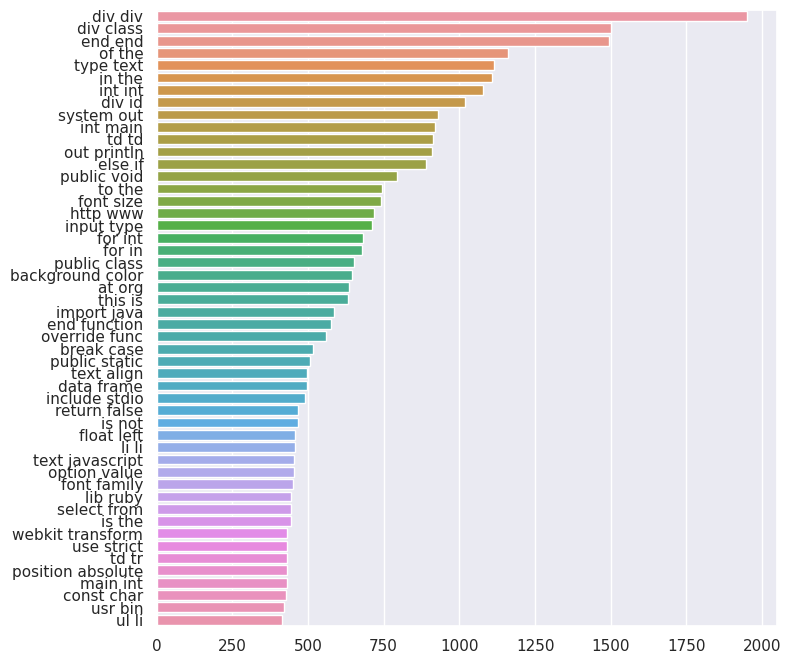

In [22]:
words, frequency = [], []
for word, count in zip(ngram_freq['ngram'][:50], ngram_freq['frequency'][:50]):
    words.append(word)
    frequency.append(count)
    
sns.set(rc={'figure.figsize':(8,8)})
sns.barplot(x = frequency, y = words)

In [23]:
from wordcloud import WordCloud
# stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        # stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Split on train and test sets

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df

language                                               code
0            c  #include <stdio.h>\n#include <stdlib.h>\n\n#de...
1            c  #include <stdlib.h>\n#include <string.h>\n#inc...
2            c  #include <stdio.h>\n#include <stdlib.h>\n\nflo...
3            c  write(1)\nwall(1)\n#include <stdlib.h>\n#inclu...
4            c  while(ch = getchar(), ch >= 0)\n// from main()...
...        ...                                                ...
15040    swift  UIDatePicker\nif theDatePicker == strDate {\n ...
15041    swift  ...\n//var memoArea = UITextView(frame: CGRect...
15042    swift  let nextView = self.storyboard?.instantiateVie...
15043    swift   import UIKit\n import CoreLocation\n class Vi...
15044    swift      let strExpression = "a+b+20"\n    let exp ...

[15045 rows x 2 columns]

In [26]:
train, test = train_test_split(df, random_state=42)

In [27]:
train.to_csv('train.csv', index=None)
test.to_csv('test.csv', index=None)